In [16]:
import pandas as pd
import joblib
import warnings
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from raiwidgets import ResponsibleAIDashboard
from responsibleai import RAIInsights
from responsibleai.feature_metadata import FeatureMetadata

warnings.filterwarnings('ignore')

print("\n" + "="*70)
print("RESPONSIBLE AI DASHBOARD - HEART DISEASE PREDICTION")
print("="*70)

# ==========================================================
# CONFIGURATION
# ==========================================================

CATEGORICAL_MAPPINGS = {
    'Sex': {1: 'Female', 2: 'Male'},
    'Cholesterol_Level': {1: 'Normal', 2: 'Borderline High', 3: 'High'},
    'Glucose_Level': {1: 'Normal', 2: 'Prediabetes', 3: 'Diabetes'},
    'Smoking_Status': {1: 'Non-Smoker', 2: 'Smoker'},
    'Alcohol_Intake': {1: 'No/Rarely', 2: 'Yes/Regularly'},
    'Physical_Activity': {1: 'Active', 2: 'Inactive/Low'},
    'Age_Group': {1: '<40', 2: '40-44', 3: '45-49', 4: '50-54', 5: '55-59', 6: '60-64', 7: '65-69', 8: '70+'},
    'BMI_Group': {1: 'Normal/Underweight', 2: 'Overweight', 3: 'Obese I', 4: 'Obese II/III'},
    'BP_Group': {1: 'Normal', 2: 'Elevated', 3: 'Stage 1 Hypertension', 4: 'Stage 2+ Hypertension'},
}

# Paths
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / 'artifacts' / 'split data sets'
MODEL_DIR = PROJECT_ROOT / 'artifacts' / 'model'

TARGET_COLUMN = 'Heart_Disease'
SAMPLE_SIZE = 5000
RANDOM_STATE = 42

# ==========================================================
# LOAD MODEL
# ==========================================================

print("\n[1/4] Loading model...")

# First try to load the complete package
package_path = MODEL_DIR / 'complete_model_package.pkl'
calibrated_path = MODEL_DIR / 'calibrated_model.pkl'

if package_path.exists():
    print("Loading from complete package...")
    package = joblib.load(package_path)
    
    # Use the selected model from the package (which is already the best one)
    model_to_use = package['selected_model']
    model_type = package['selected_type']
    features = package['features']
    
    print(f"✓ Loaded: {package['model_type']} ({model_type.upper()})")
    
elif calibrated_path.exists():
    print("Loading calibrated model...")
    model_to_use = joblib.load(calibrated_path)
    model_type = 'calibrated'
    features = None
    
    print(f"✓ Loaded: Calibrated model")
    
else:
    raise FileNotFoundError(f"No model found in {MODEL_DIR}")

# ==========================================================
# LOAD DATA
# ==========================================================

print("\n[2/4] Loading data...")
X_train = pd.read_parquet(DATA_DIR / 'X_train.parquet')
X_test = pd.read_parquet(DATA_DIR / 'X_test.parquet')
y_train = pd.read_parquet(DATA_DIR / 'y_train.parquet').iloc[:, 0]
y_test = pd.read_parquet(DATA_DIR / 'y_test.parquet').iloc[:, 0]

if features:
    X_train = X_train[features]
    X_test = X_test[features]
else:
    features = X_train.columns.tolist()

print(f"✓ Train: {X_train.shape}, Test: {X_test.shape}")

# ==========================================================
# DECODE CATEGORICAL FEATURES
# ==========================================================

print("\n[3/4] Decoding categorical features...")

def decode_categorical_features(df, mappings):
    df_decoded = df.copy()
    for col, mapping in mappings.items():
        if col in df_decoded.columns:
            df_decoded[col] = df_decoded[col].apply(
                lambda x: mapping.get(int(round(x)), str(int(round(x))))
            ).astype('category')
    return df_decoded

X_train_decoded = decode_categorical_features(X_train, CATEGORICAL_MAPPINGS)
X_test_decoded = decode_categorical_features(X_test, CATEGORICAL_MAPPINGS)

categorical_features = [col for col in CATEGORICAL_MAPPINGS.keys() 
                       if col in X_train_decoded.columns]

print(f"✓ Categorical features: {len(categorical_features)}")

# ==========================================================
# MODEL WRAPPER
# ==========================================================

class RAICompatibleWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, categorical_mappings, features):
        self.model = model
        self.categorical_mappings = categorical_mappings
        self.features = features
        self.classes_ = np.array([0, 1])
        
        # Create reverse mappings (text -> numeric)
        self.reverse_mappings = {}
        for feat, mapping in categorical_mappings.items():
            self.reverse_mappings[feat] = {v: k for k, v in mapping.items()}
    
    def _encode_features(self, X):
        if isinstance(X, pd.DataFrame):
            X_encoded = X.copy()
            for col in X_encoded.columns:
                if col in self.reverse_mappings:
                    X_encoded[col] = X_encoded[col].astype(str).map(
                        self.reverse_mappings[col]
                    )
            # Ensure correct feature order
            if self.features:
                X_encoded = X_encoded[self.features]
            return X_encoded.values
        return X
    
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        X_numeric = self._encode_features(X)
        return self.model.predict(X_numeric)
    
    def predict_proba(self, X):
        X_numeric = self._encode_features(X)
        return self.model.predict_proba(X_numeric)

rai_model = RAICompatibleWrapper(model_to_use, CATEGORICAL_MAPPINGS, features)
print(f"✓ Model wrapped ({model_type})")

# ==========================================================
# PREPARE SAMPLES
# ==========================================================

print("\n[4/4] Preparing samples...")

# Sample training data
if len(X_train_decoded) > SAMPLE_SIZE:
    _, X_train_sample, _, y_train_sample = train_test_split(
        X_train_decoded, y_train, 
        test_size=SAMPLE_SIZE, 
        stratify=y_train, 
        random_state=RANDOM_STATE
    )
else:
    X_train_sample, y_train_sample = X_train_decoded, y_train

# Sample test data
if len(X_test_decoded) > SAMPLE_SIZE:
    _, X_test_sample, _, y_test_sample = train_test_split(
        X_test_decoded, y_test, 
        test_size=SAMPLE_SIZE, 
        stratify=y_test, 
        random_state=RANDOM_STATE
    )
else:
    X_test_sample, y_test_sample = X_test_decoded, y_test

# Combine features and target
train_data = X_train_sample.copy()
train_data[TARGET_COLUMN] = y_train_sample.values.astype(int)

test_data = X_test_sample.copy()
test_data[TARGET_COLUMN] = y_test_sample.values.astype(int)

print(f"✓ Train: {train_data.shape}, Test: {test_data.shape}")

# ==========================================================
# INITIALIZE RAI DASHBOARD
# ==========================================================

print("\n" + "="*70)
print("INITIALIZING DASHBOARD")
print("="*70)

# Create RAI Insights
print("\nCreating RAI Insights...")
rai_insights = RAIInsights(
    model=rai_model,
    train=train_data,
    test=test_data,
    target_column=TARGET_COLUMN,
    task_type='classification',
    feature_metadata=FeatureMetadata(
        categorical_features=categorical_features,
        dropped_features=[]
    )
)

# Add components
print("\n📊 Adding components...")
print("   • Explainability (SHAP)...")
rai_insights.explainer.add()

print("   • Error Analysis...")
rai_insights.error_analysis.add()

# Compute
print("\n⏳ Computing (3-5 minutes)...\n")
rai_insights.compute()

# Launch
print("\n✅ Done! Launching dashboard...\n")
ResponsibleAIDashboard(rai_insights)


RESPONSIBLE AI DASHBOARD - HEART DISEASE PREDICTION

[1/4] Loading model...
Loading from complete package...
✓ Loaded: XGBoost (BASE)

[2/4] Loading data...
✓ Train: (48983, 13), Test: (20993, 13)

[3/4] Decoding categorical features...
✓ Categorical features: 9
✓ Model wrapped (base)

[4/4] Preparing samples...
✓ Train: (5000, 14), Test: (5000, 14)

INITIALIZING DASHBOARD

Creating RAI Insights...

📊 Adding components...
   • Explainability (SHAP)...
   • Error Analysis...

⏳ Computing (3-5 minutes)...

Causal Effects
Current Status: Generating Causal Effects.
Current Status: Finished generating causal effects.
Time taken: 0.0 min 0.0008495000074617565 sec
Counterfactual
Time taken: 0.0 min 3.260001540184021e-05 sec
Error Analysis
Current Status: Generating error analysis reports.
Current Status: Finished generating error analysis reports.
Time taken: 0.0 min 0.5067759000230581 sec
Explanations
Current Status: Explaining 13 features
[LightGBM] [Info] Auto-choosing row-wise multi-thre

In [17]:
# ============================================================================
# RISK PROFILE SEGMENTATION - CREATE LOW/MEDIUM/HIGH RISK DATAFRAMES
# ============================================================================

import numpy as np
import pandas as pd
from pathlib import Path

print("⚡ Creating Risk-Based Dataframes\n")

# ============================================================================
# SETUP PATHS
# ============================================================================

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
METRICS_DIR = REPORTS_DIR / 'metrics'

# ============================================================================
# LOAD RISK PROFILES
# ============================================================================

print("[1/2] Loading risk profiles...")
risk_profiles_path = METRICS_DIR / 'df_risk_profiles.parquet'

if not risk_profiles_path.exists():
    raise FileNotFoundError(f"Risk profiles not found: {risk_profiles_path}\nPlease run risk scoring analysis first.")

df_risk_profiles = pd.read_parquet(risk_profiles_path)
print(f"✓ Loaded risk profiles: {df_risk_profiles.shape}")

# ============================================================================
# CREATE RISK-SPECIFIC DATAFRAMES
# ============================================================================

print("\n[2/2] Creating risk-specific dataframes...")

# Low Risk
df_low_risk = df_risk_profiles[df_risk_profiles['Risk_Label'] == 'Low'].copy()
df_low_risk.reset_index(drop=True, inplace=True)

# Medium Risk
df_medium_risk = df_risk_profiles[df_risk_profiles['Risk_Label'] == 'Medium'].copy()
df_medium_risk.reset_index(drop=True, inplace=True)

# High Risk
df_high_risk = df_risk_profiles[df_risk_profiles['Risk_Label'] == 'High'].copy()
df_high_risk.reset_index(drop=True, inplace=True)

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*90)
print("RISK PROFILE SUMMARY")
print("="*90)

summary_stats = []

for risk_level, df_risk in [
    ('Low', df_low_risk),
    ('Medium', df_medium_risk),
    ('High', df_high_risk)
]:
    total_count = len(df_risk)
    disease_count = int(df_risk['Actual_Disease'].sum()) if total_count > 0 else 0
    disease_rate = (disease_count / total_count * 100) if total_count > 0 else 0
    
    avg_score = df_risk['Risk_Score'].mean() if total_count > 0 else 0
    min_score = df_risk['Risk_Score'].min() if total_count > 0 else 0
    max_score = df_risk['Risk_Score'].max() if total_count > 0 else 0
    std_score = df_risk['Risk_Score'].std() if total_count > 0 else 0
    
    summary_stats.append({
        'Risk_Level': risk_level,
        'Total_Patients': total_count,
        'Percentage_of_Total': (total_count / len(df_risk_profiles) * 100),
        'Disease_Count': disease_count,
        'Disease_Rate_%': disease_rate,
        'Avg_Risk_Score': avg_score,
        'Std_Risk_Score': std_score,
        'Min_Risk_Score': min_score,
        'Max_Risk_Score': max_score
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_string(index=False))
print("="*90)

print(f"\n✓ df_low_risk: {df_low_risk.shape[0]:,} patients")
print(f"✓ df_medium_risk: {df_medium_risk.shape[0]:,} patients")
print(f"✓ df_high_risk: {df_high_risk.shape[0]:,} patients")

print("\n✅ Risk dataframes created successfully!")
print("="*90)

⚡ Creating Risk-Based Dataframes

[1/2] Loading risk profiles...
✓ Loaded risk profiles: (69976, 16)

[2/2] Creating risk-specific dataframes...

RISK PROFILE SUMMARY
Risk_Level  Total_Patients  Percentage_of_Total  Disease_Count  Disease_Rate_%  Avg_Risk_Score  Std_Risk_Score  Min_Risk_Score  Max_Risk_Score
       Low           21277            30.406139           3644       17.126475        0.191095        0.071067        0.025550        0.299990
    Medium           16667            23.818166           6566       39.395212        0.389954        0.055973        0.300005        0.499996
      High           32032            45.775695          24762       77.303946        0.761868        0.121419        0.500000        0.953886

✓ df_low_risk: 21,277 patients
✓ df_medium_risk: 16,667 patients
✓ df_high_risk: 32,032 patients

✅ Risk dataframes created successfully!


⚡ Low Risk Group - Specific Features Count Analysis



Total low risk patients: 21,277

✓ Available features (9): ['Sex', 'Cholesterol_Level', 'Glucose_Level', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity', 'Age_Group', 'BP_Group', 'BMI_Group']

✓ Successfully counted 9 features

✓ Saved: 03_low_risk_group_features.png


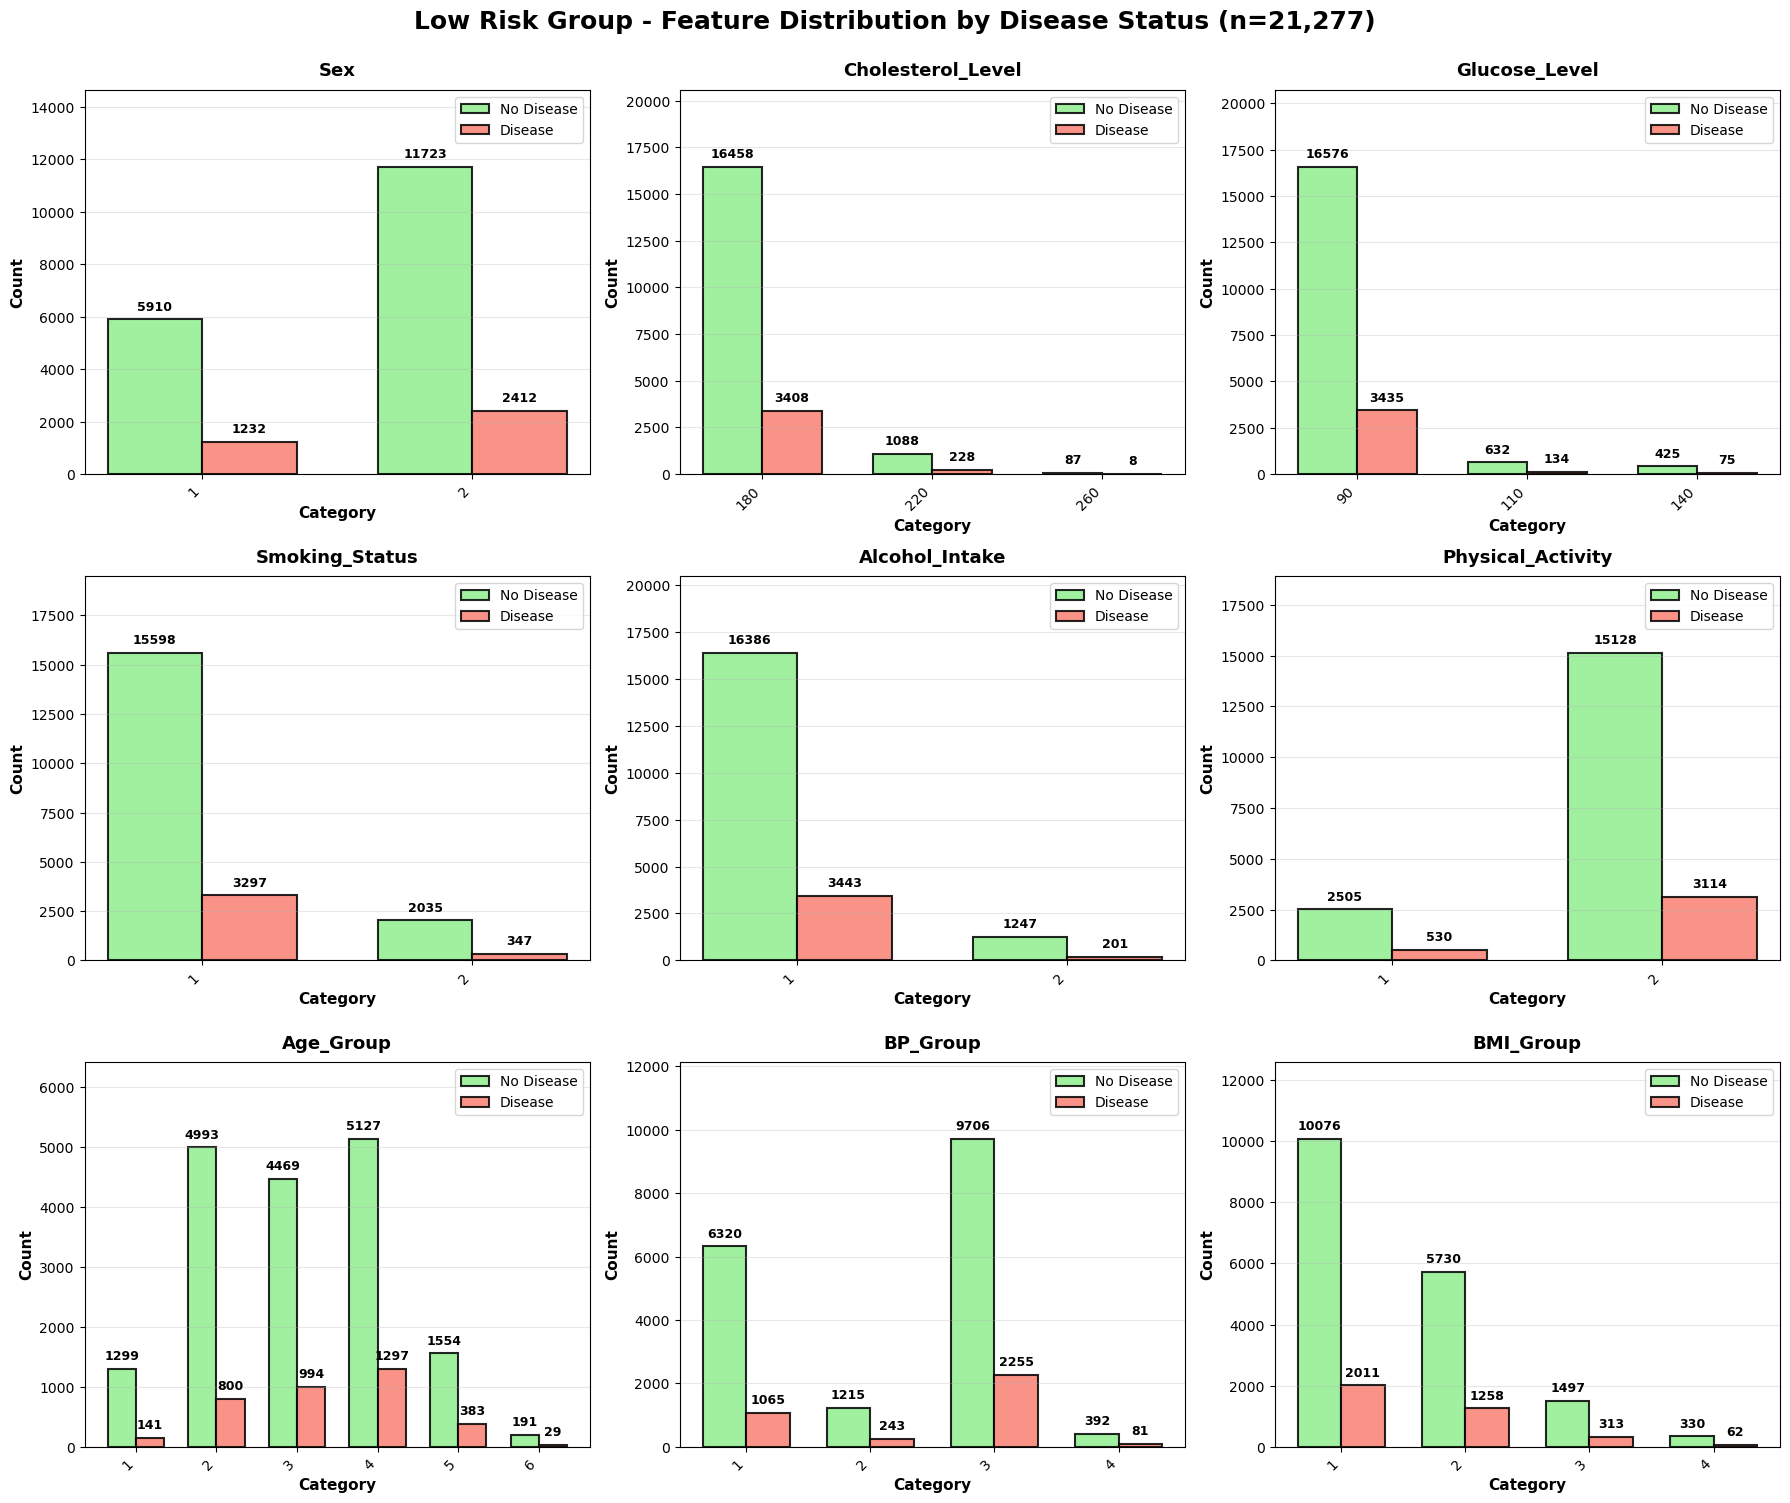

In [18]:
# ============================================================================
# LOW RISK GROUP - SPECIFIC FEATURES BAR PLOT (COUNTS BY TARGET LABEL)
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

print("⚡ Low Risk Group - Specific Features Count Analysis\n")

# ============================================================================
# SETUP PATHS
# ============================================================================

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
FIGURES_DIR = REPORTS_DIR / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================================
# CONFIGURATION
# ============================================================================

TARGET_COLORS = {'No Disease': 'lightgreen', 'Disease': 'salmon'}

# ============================================================================
# PREPARE DATA
# ============================================================================

print(f"Total low risk patients: {len(df_low_risk):,}\n")

# Create target label if needed
if 'Target_Label' not in df_low_risk.columns:
    df_low_risk['Target_Label'] = df_low_risk['Actual_Disease'].map({
        0: 'No Disease', 
        1: 'Disease'
    })

# ============================================================================
# DEFINE FEATURES TO ANALYZE
# ============================================================================

features_to_analyze = [
    'Sex', 
    'Cholesterol_Level', 
    'Glucose_Level', 
    'Smoking_Status',
    'Alcohol_Intake', 
    'Physical_Activity', 
    'Age_Group',
    'BP_Group', 
    'BMI_Group'
]

# Check which features exist in the dataframe
available_features = [f for f in features_to_analyze if f in df_low_risk.columns]
missing_features = [f for f in features_to_analyze if f not in df_low_risk.columns]

print(f"✓ Available features ({len(available_features)}): {available_features}")
if missing_features:
    print(f"⚠ Missing features ({len(missing_features)}): {missing_features}")
print()

# ============================================================================
# COUNT PATIENTS BY CATEGORY FOR EACH FEATURE
# ============================================================================

feature_counts = {}

for feature in available_features:
    # Count by category and target
    counts = df_low_risk.groupby([feature, 'Target_Label']).size().unstack(fill_value=0)
    
    # Ensure both columns exist
    if 'No Disease' not in counts.columns:
        counts['No Disease'] = 0
    if 'Disease' not in counts.columns:
        counts['Disease'] = 0
    
    counts = counts[['No Disease', 'Disease']]
    
    # Sort index if needed (for ordered categories)
    feature_counts[feature] = counts

print(f"✓ Successfully counted {len(feature_counts)} features\n")

# ============================================================================
# CREATE SUBPLOT BAR PLOTS
# ============================================================================

n_features = len(feature_counts)
n_cols = 3  # 3 columns
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
fig.suptitle(f'Low Risk Group - Feature Distribution by Disease Status (n={len(df_low_risk):,})', 
             fontsize=18, fontweight='bold', y=0.999)

# Flatten axes for easy iteration
if n_features > 1:
    axes = axes.flatten()
else:
    axes = [axes]

# Plot each feature
for idx, (feature_name, counts) in enumerate(feature_counts.items()):
    ax = axes[idx]
    
    x = np.arange(len(counts.index))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, counts['No Disease'], width,
                   label='No Disease', color=TARGET_COLORS['No Disease'],
                   edgecolor='black', alpha=0.85, linewidth=1.5)
    
    bars2 = ax.bar(x + width/2, counts['Disease'], width,
                   label='Disease', color=TARGET_COLORS['Disease'],
                   edgecolor='black', alpha=0.85, linewidth=1.5)
    
    ax.set_title(f'{feature_name}', fontsize=13, fontweight='bold', pad=10)
    ax.set_xlabel('Category', fontsize=11, fontweight='bold')
    ax.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(counts.index, rotation=45, ha='right', fontsize=10)
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(alpha=0.3, axis='y')
    
    # Add count labels
    max_height = counts.values.max() if counts.values.max() > 0 else 1
    ax.set_ylim([0, max_height * 1.25])
    
    for bar in bars1:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + max_height * 0.02,
                    f'{int(height)}', ha='center', va='bottom',
                    fontsize=9, fontweight='bold')
    
    for bar in bars2:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + max_height * 0.02,
                    f'{int(height)}', ha='center', va='bottom',
                    fontsize=9, fontweight='bold')

# Hide extra subplots if any
for idx in range(len(feature_counts), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()

# ============================================================================
# SAVE FIGURE
# ============================================================================

output_path = FIGURES_DIR / '03_low_risk_group_features.png'
print(f"✓ Saved: {output_path.name}")
plt.show()
plt.close()


⚡ Medium Risk Group - Specific Features Count Analysis

Total medium risk patients: 16,667

✓ Available features (9): ['Sex', 'Cholesterol_Level', 'Glucose_Level', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity', 'Age_Group', 'BP_Group', 'BMI_Group']

✓ Successfully counted 9 features

✓ Saved: df_medium_risk.png


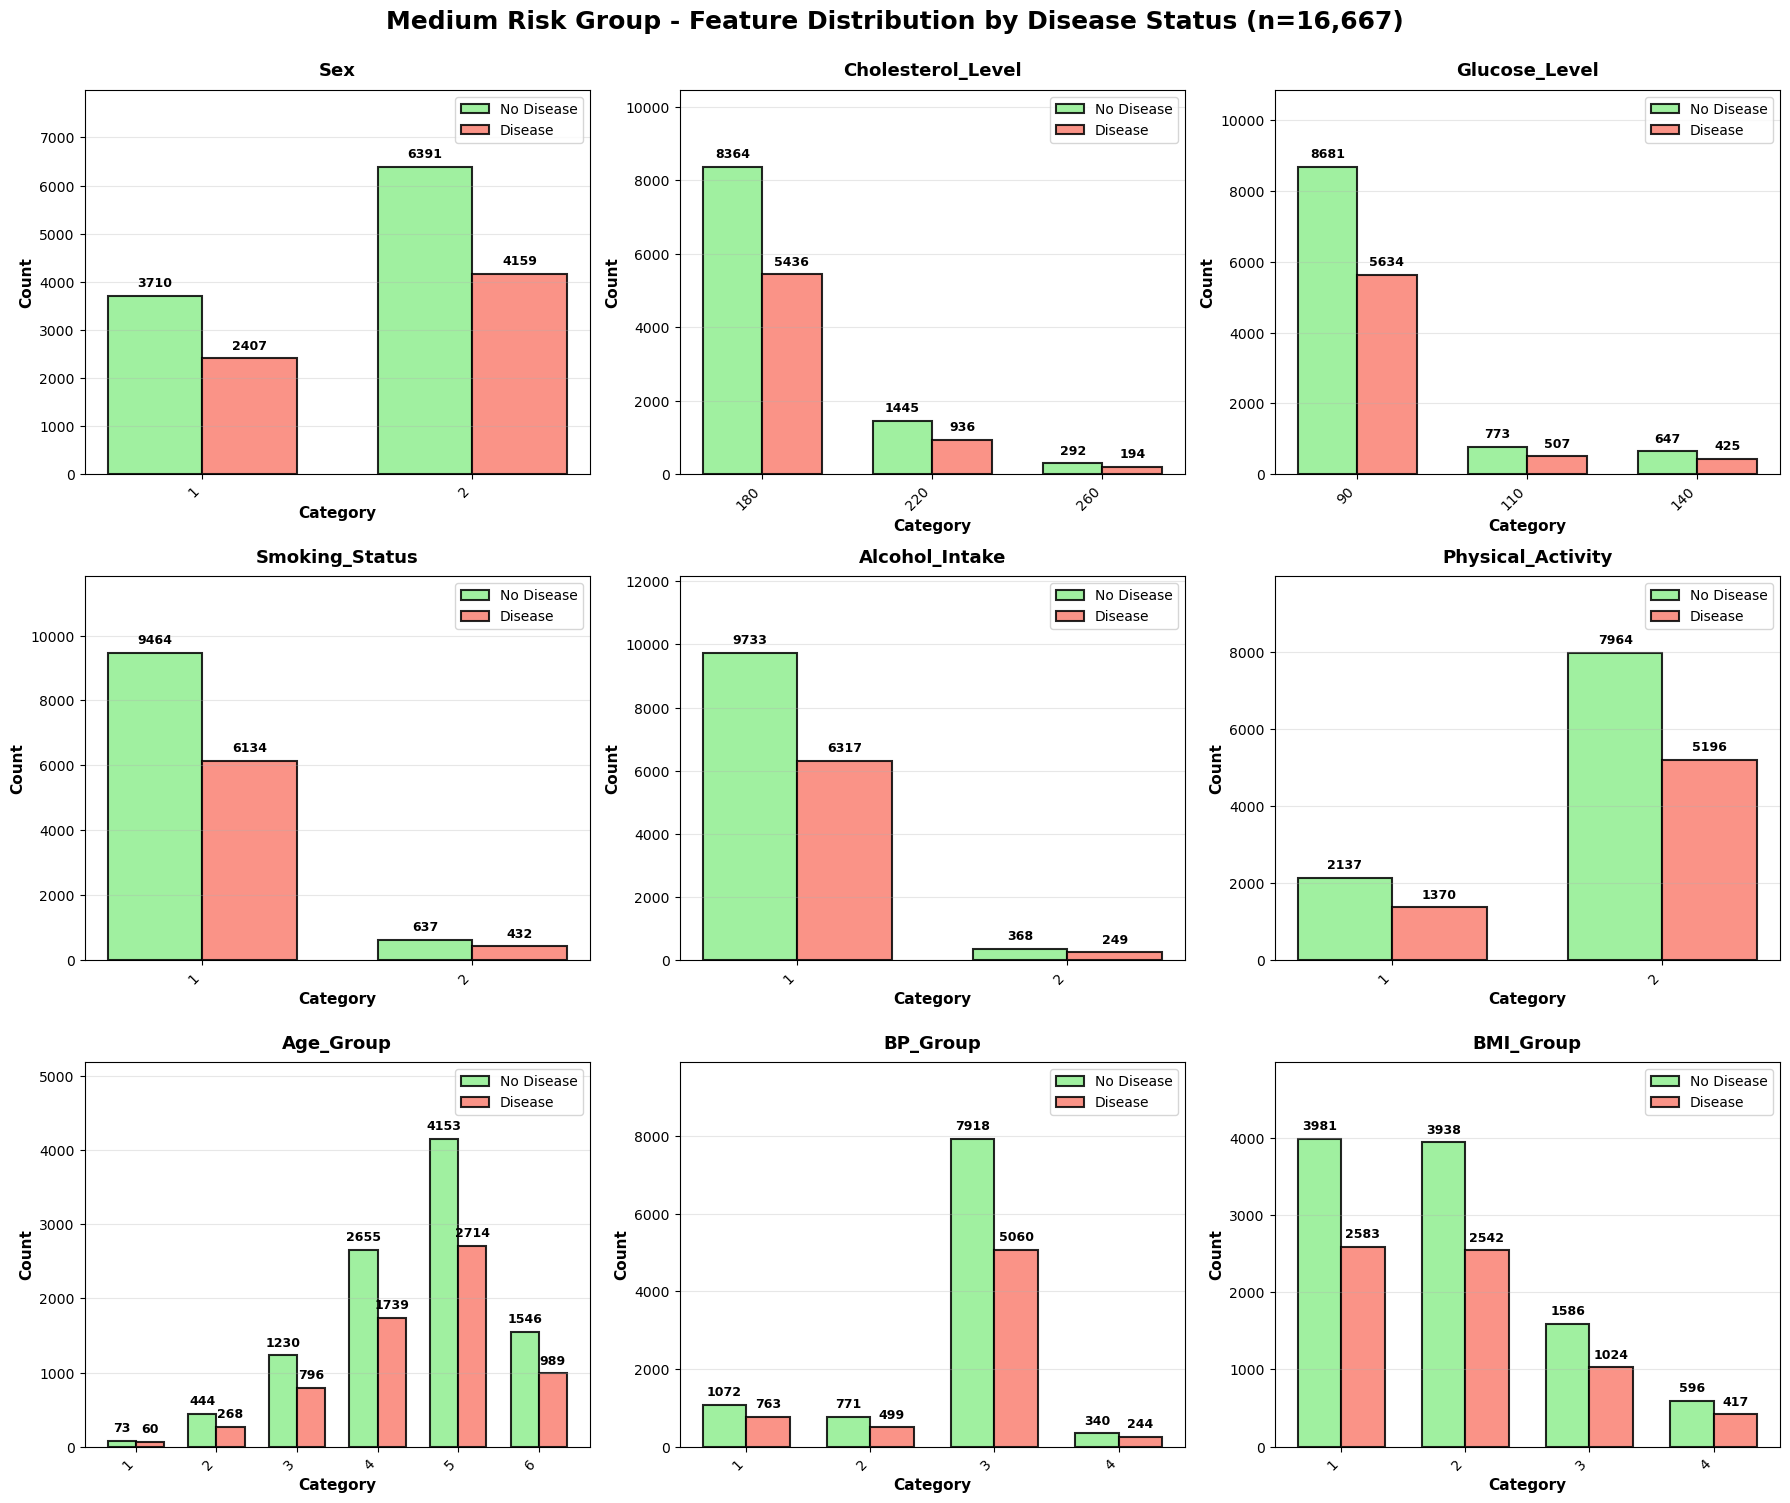

In [19]:
# ============================================================================
# Medium RISK GROUP - SPECIFIC FEATURES BAR PLOT (COUNTS BY TARGET LABEL)
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

print("⚡ Medium Risk Group - Specific Features Count Analysis\n")

# ============================================================================
# SETUP PATHS
# ============================================================================

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling' 
FIGURES_DIR = REPORTS_DIR / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================================
# CONFIGURATION
# ============================================================================

TARGET_COLORS = {'No Disease': 'lightgreen', 'Disease': 'salmon'}

# ============================================================================
# PREPARE DATA
# ============================================================================

print(f"Total medium risk patients: {len(df_medium_risk):,}\n")

# Create target label if needed
if 'Target_Label' not in df_medium_risk.columns:
    df_medium_risk['Target_Label'] = df_medium_risk['Actual_Disease'].map({
        0: 'No Disease', 
        1: 'Disease'
    })

# ============================================================================
# DEFINE FEATURES TO ANALYZE
# ============================================================================

features_to_analyze = [
    'Sex', 
    'Cholesterol_Level', 
    'Glucose_Level', 
    'Smoking_Status',
    'Alcohol_Intake', 
    'Physical_Activity', 
    'Age_Group',
    'BP_Group', 
    'BMI_Group'
]

# Check which features exist in the dataframe
available_features = [f for f in features_to_analyze if f in df_medium_risk.columns]
missing_features = [f for f in features_to_analyze if f not in df_medium_risk.columns]

print(f"✓ Available features ({len(available_features)}): {available_features}")
if missing_features:
    print(f"⚠ Missing features ({len(missing_features)}): {missing_features}")
print()

# ============================================================================
# COUNT PATIENTS BY CATEGORY FOR EACH FEATURE
# ============================================================================

feature_counts = {}

for feature in available_features:
    # Count by category and target
    counts = df_medium_risk.groupby([feature, 'Target_Label']).size().unstack(fill_value=0)
    
    # Ensure both columns exist
    if 'No Disease' not in counts.columns:
        counts['No Disease'] = 0
    if 'Disease' not in counts.columns:
        counts['Disease'] = 0
    
    counts = counts[['No Disease', 'Disease']]
    
    # Sort index if needed (for ordered categories)
    feature_counts[feature] = counts

print(f"✓ Successfully counted {len(feature_counts)} features\n")

# ============================================================================
# CREATE SUBPLOT BAR PLOTS
# ============================================================================

n_features = len(feature_counts)
n_cols = 3  # 3 columns
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
fig.suptitle(f'Medium Risk Group - Feature Distribution by Disease Status (n={len(df_medium_risk):,})', 
             fontsize=18, fontweight='bold', y=0.999)

# Flatten axes for easy iteration
if n_features > 1:
    axes = axes.flatten()
else:
    axes = [axes]

# Plot each feature
for idx, (feature_name, counts) in enumerate(feature_counts.items()):
    ax = axes[idx]
    
    x = np.arange(len(counts.index))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, counts['No Disease'], width,
                   label='No Disease', color=TARGET_COLORS['No Disease'],
                   edgecolor='black', alpha=0.85, linewidth=1.5)
    
    bars2 = ax.bar(x + width/2, counts['Disease'], width,
                   label='Disease', color=TARGET_COLORS['Disease'],
                   edgecolor='black', alpha=0.85, linewidth=1.5)
    
    ax.set_title(f'{feature_name}', fontsize=13, fontweight='bold', pad=10)
    ax.set_xlabel('Category', fontsize=11, fontweight='bold')
    ax.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(counts.index, rotation=45, ha='right', fontsize=10)
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(alpha=0.3, axis='y')
    
    # Add count labels
    max_height = counts.values.max() if counts.values.max() > 0 else 1
    ax.set_ylim([0, max_height * 1.25])
    
    for bar in bars1:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + max_height * 0.02,
                    f'{int(height)}', ha='center', va='bottom',
                    fontsize=9, fontweight='bold')
    
    for bar in bars2:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + max_height * 0.02,
                    f'{int(height)}', ha='center', va='bottom',
                    fontsize=9, fontweight='bold')

# Hide extra subplots if any
for idx in range(len(feature_counts), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()

# ============================================================================
# SAVE FIGURE
# ============================================================================

output_path = FIGURES_DIR / 'df_medium_risk.png'
print(f"✓ Saved: {output_path.name}")
plt.show()
plt.close()


⚡ High Risk Group - Specific Features Count Analysis

Total medium risk patients: 32,032

✓ Available features (9): ['Sex', 'Cholesterol_Level', 'Glucose_Level', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity', 'Age_Group', 'BP_Group', 'BMI_Group']

✓ Successfully counted 9 features

✓ Saved: df_high_risk.png


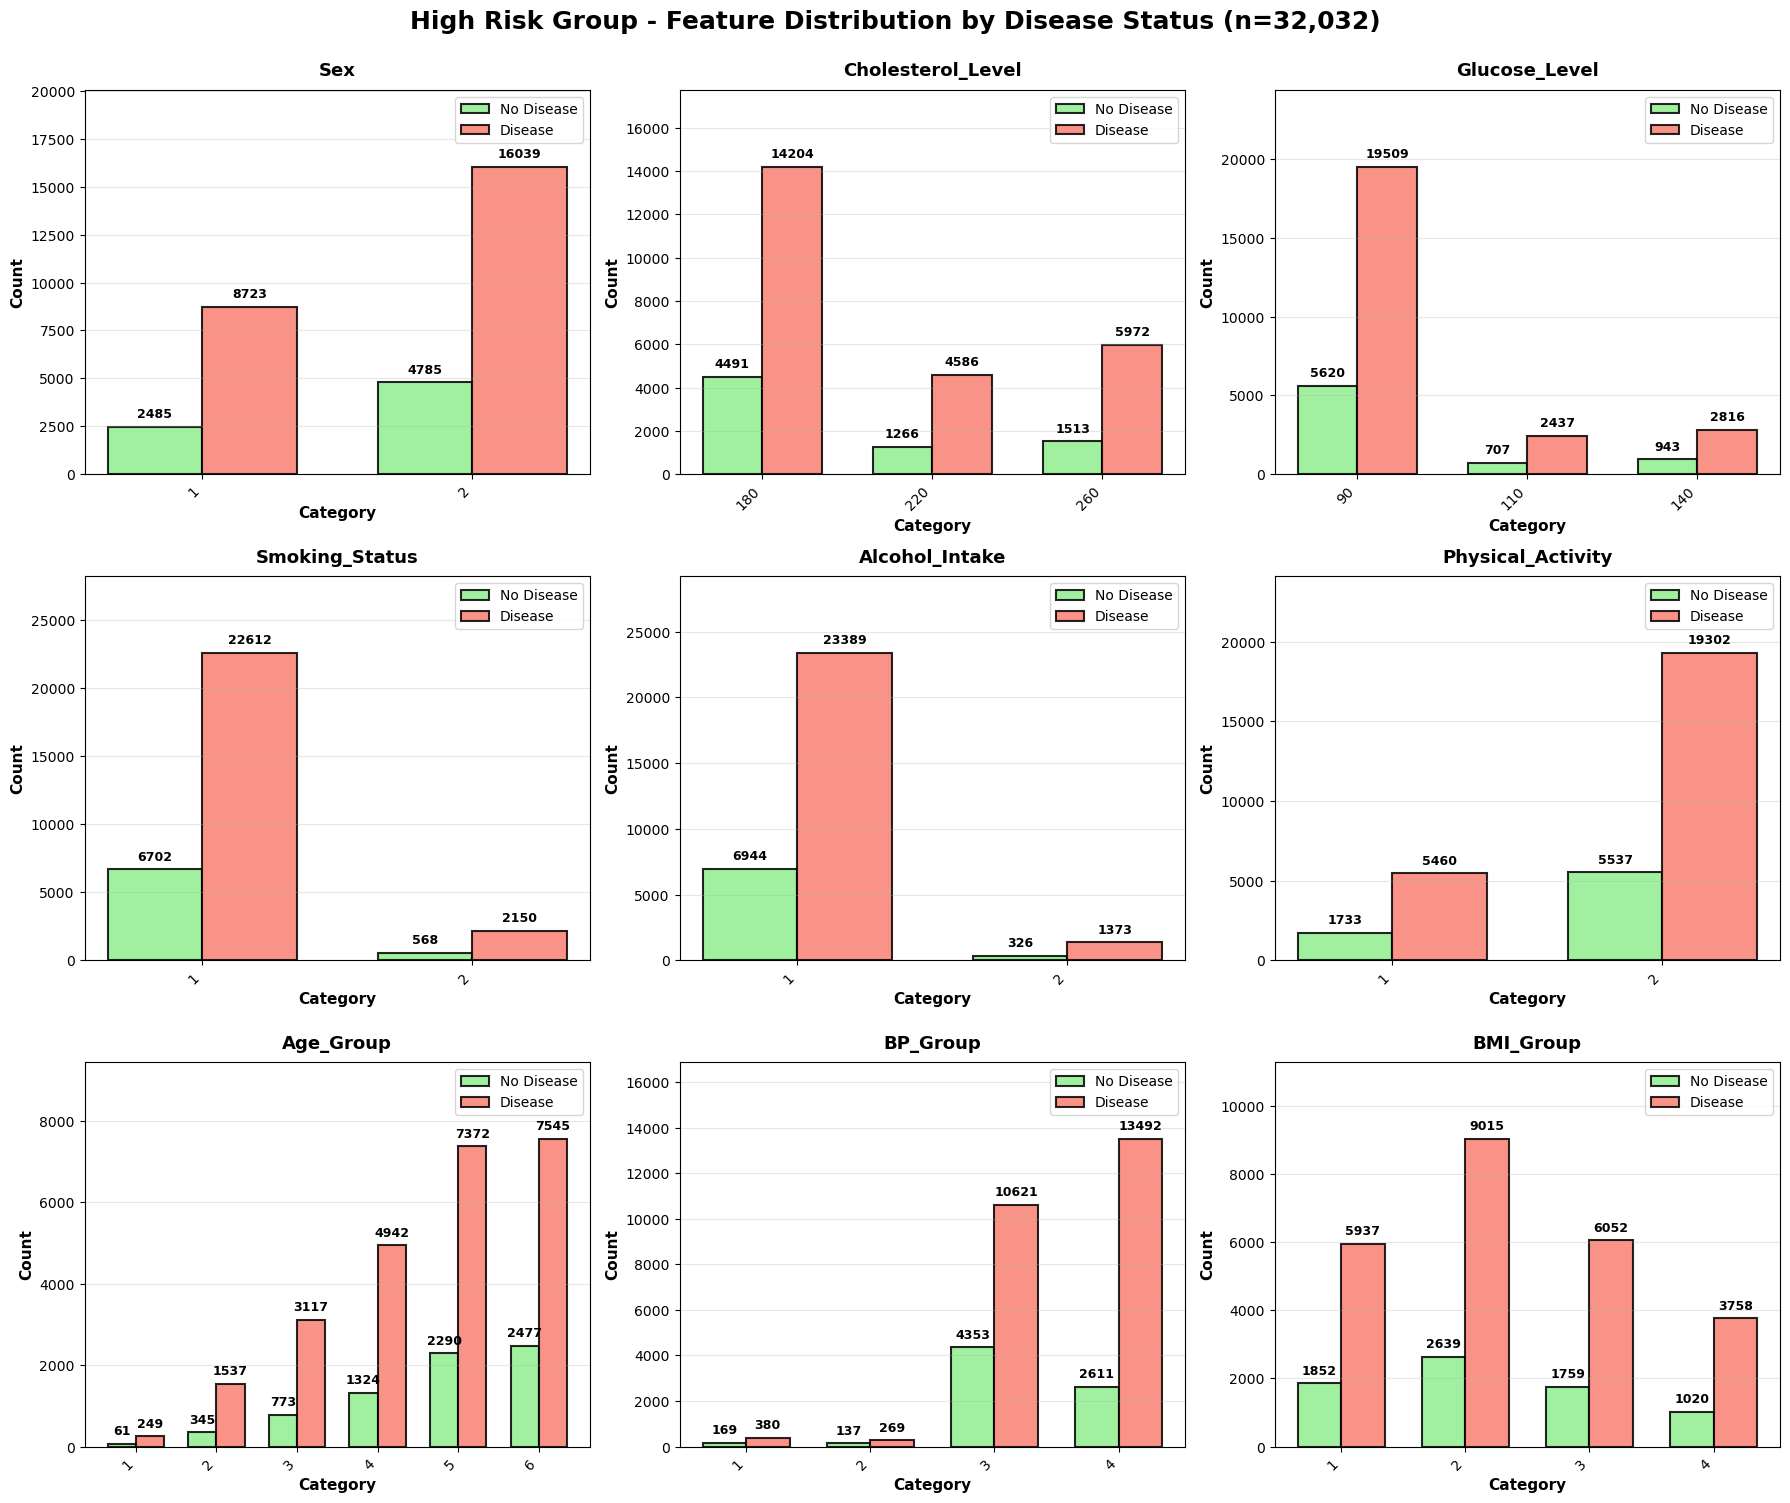

In [20]:
# ============================================================================
# high RISK GROUP - SPECIFIC FEATURES BAR PLOT (COUNTS BY TARGET LABEL)
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

print("⚡ High Risk Group - Specific Features Count Analysis\n")

# ============================================================================
# SETUP PATHS
# ============================================================================

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
FIGURES_DIR = REPORTS_DIR / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================================
# CONFIGURATION
# ============================================================================

TARGET_COLORS = {'No Disease': 'lightgreen', 'Disease': 'salmon'}

# ============================================================================
# PREPARE DATA
# ============================================================================

print(f"Total medium risk patients: {len(df_high_risk):,}\n")

# Create target label if needed
if 'Target_Label' not in df_high_risk.columns:
    df_high_risk['Target_Label'] = df_high_risk['Actual_Disease'].map({
        0: 'No Disease', 
        1: 'Disease'
    })

# ============================================================================
# DEFINE FEATURES TO ANALYZE
# ============================================================================

features_to_analyze = [
    'Sex', 
    'Cholesterol_Level', 
    'Glucose_Level', 
    'Smoking_Status',
    'Alcohol_Intake', 
    'Physical_Activity', 
    'Age_Group',
    'BP_Group', 
    'BMI_Group'
]

# Check which features exist in the dataframe
available_features = [f for f in features_to_analyze if f in df_high_risk.columns]
missing_features = [f for f in features_to_analyze if f not in df_high_risk.columns]

print(f"✓ Available features ({len(available_features)}): {available_features}")
if missing_features:
    print(f"⚠ Missing features ({len(missing_features)}): {missing_features}")
print()

# ============================================================================
# COUNT PATIENTS BY CATEGORY FOR EACH FEATURE
# ============================================================================

feature_counts = {}

for feature in available_features:
    # Count by category and target
    counts = df_high_risk.groupby([feature, 'Target_Label']).size().unstack(fill_value=0)
    
    # Ensure both columns exist
    if 'No Disease' not in counts.columns:
        counts['No Disease'] = 0
    if 'Disease' not in counts.columns:
        counts['Disease'] = 0
    
    counts = counts[['No Disease', 'Disease']]
    
    # Sort index if needed (for ordered categories)
    feature_counts[feature] = counts

print(f"✓ Successfully counted {len(feature_counts)} features\n")

# ============================================================================
# CREATE SUBPLOT BAR PLOTS
# ============================================================================

n_features = len(feature_counts)
n_cols = 3  # 3 columns
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
fig.suptitle(f'High Risk Group - Feature Distribution by Disease Status (n={len(df_high_risk):,})', 
             fontsize=18, fontweight='bold', y=0.999)

# Flatten axes for easy iteration
if n_features > 1:
    axes = axes.flatten()
else:
    axes = [axes]

# Plot each feature
for idx, (feature_name, counts) in enumerate(feature_counts.items()):
    ax = axes[idx]
    
    x = np.arange(len(counts.index))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, counts['No Disease'], width,
                   label='No Disease', color=TARGET_COLORS['No Disease'],
                   edgecolor='black', alpha=0.85, linewidth=1.5)
    
    bars2 = ax.bar(x + width/2, counts['Disease'], width,
                   label='Disease', color=TARGET_COLORS['Disease'],
                   edgecolor='black', alpha=0.85, linewidth=1.5)
    
    ax.set_title(f'{feature_name}', fontsize=13, fontweight='bold', pad=10)
    ax.set_xlabel('Category', fontsize=11, fontweight='bold')
    ax.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(counts.index, rotation=45, ha='right', fontsize=10)
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(alpha=0.3, axis='y')
    
    # Add count labels
    max_height = counts.values.max() if counts.values.max() > 0 else 1
    ax.set_ylim([0, max_height * 1.25])
    
    for bar in bars1:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + max_height * 0.02,
                    f'{int(height)}', ha='center', va='bottom',
                    fontsize=9, fontweight='bold')
    
    for bar in bars2:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + max_height * 0.02,
                    f'{int(height)}', ha='center', va='bottom',
                    fontsize=9, fontweight='bold')

# Hide extra subplots if any
for idx in range(len(feature_counts), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()

# ============================================================================
# SAVE FIGURE
# ============================================================================

output_path = FIGURES_DIR / 'df_high_risk.png'
print(f"✓ Saved: {output_path.name}")
plt.show()
plt.close()


⚡ High Risk Group - BP Normal/Elevated - Feature Analysis

📊 Original High Risk Group: 31,972 patients

🎯 Filtered Subset (BP: Normal/Elevated): 938 patients

BP Group Distribution in Subset:
  BP Group 1: 536 (57.1%)
  BP Group 2: 402 (42.9%)

Disease Distribution:
  Disease: 651 (69.4%)
  No Disease: 287 (30.6%)

✓ Available features (8): ['Sex', 'Cholesterol_Level', 'Glucose_Level', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity', 'Age_Group', 'BMI_Group']

✓ Successfully counted 8 features

✅ Saved: df_high_risk.png



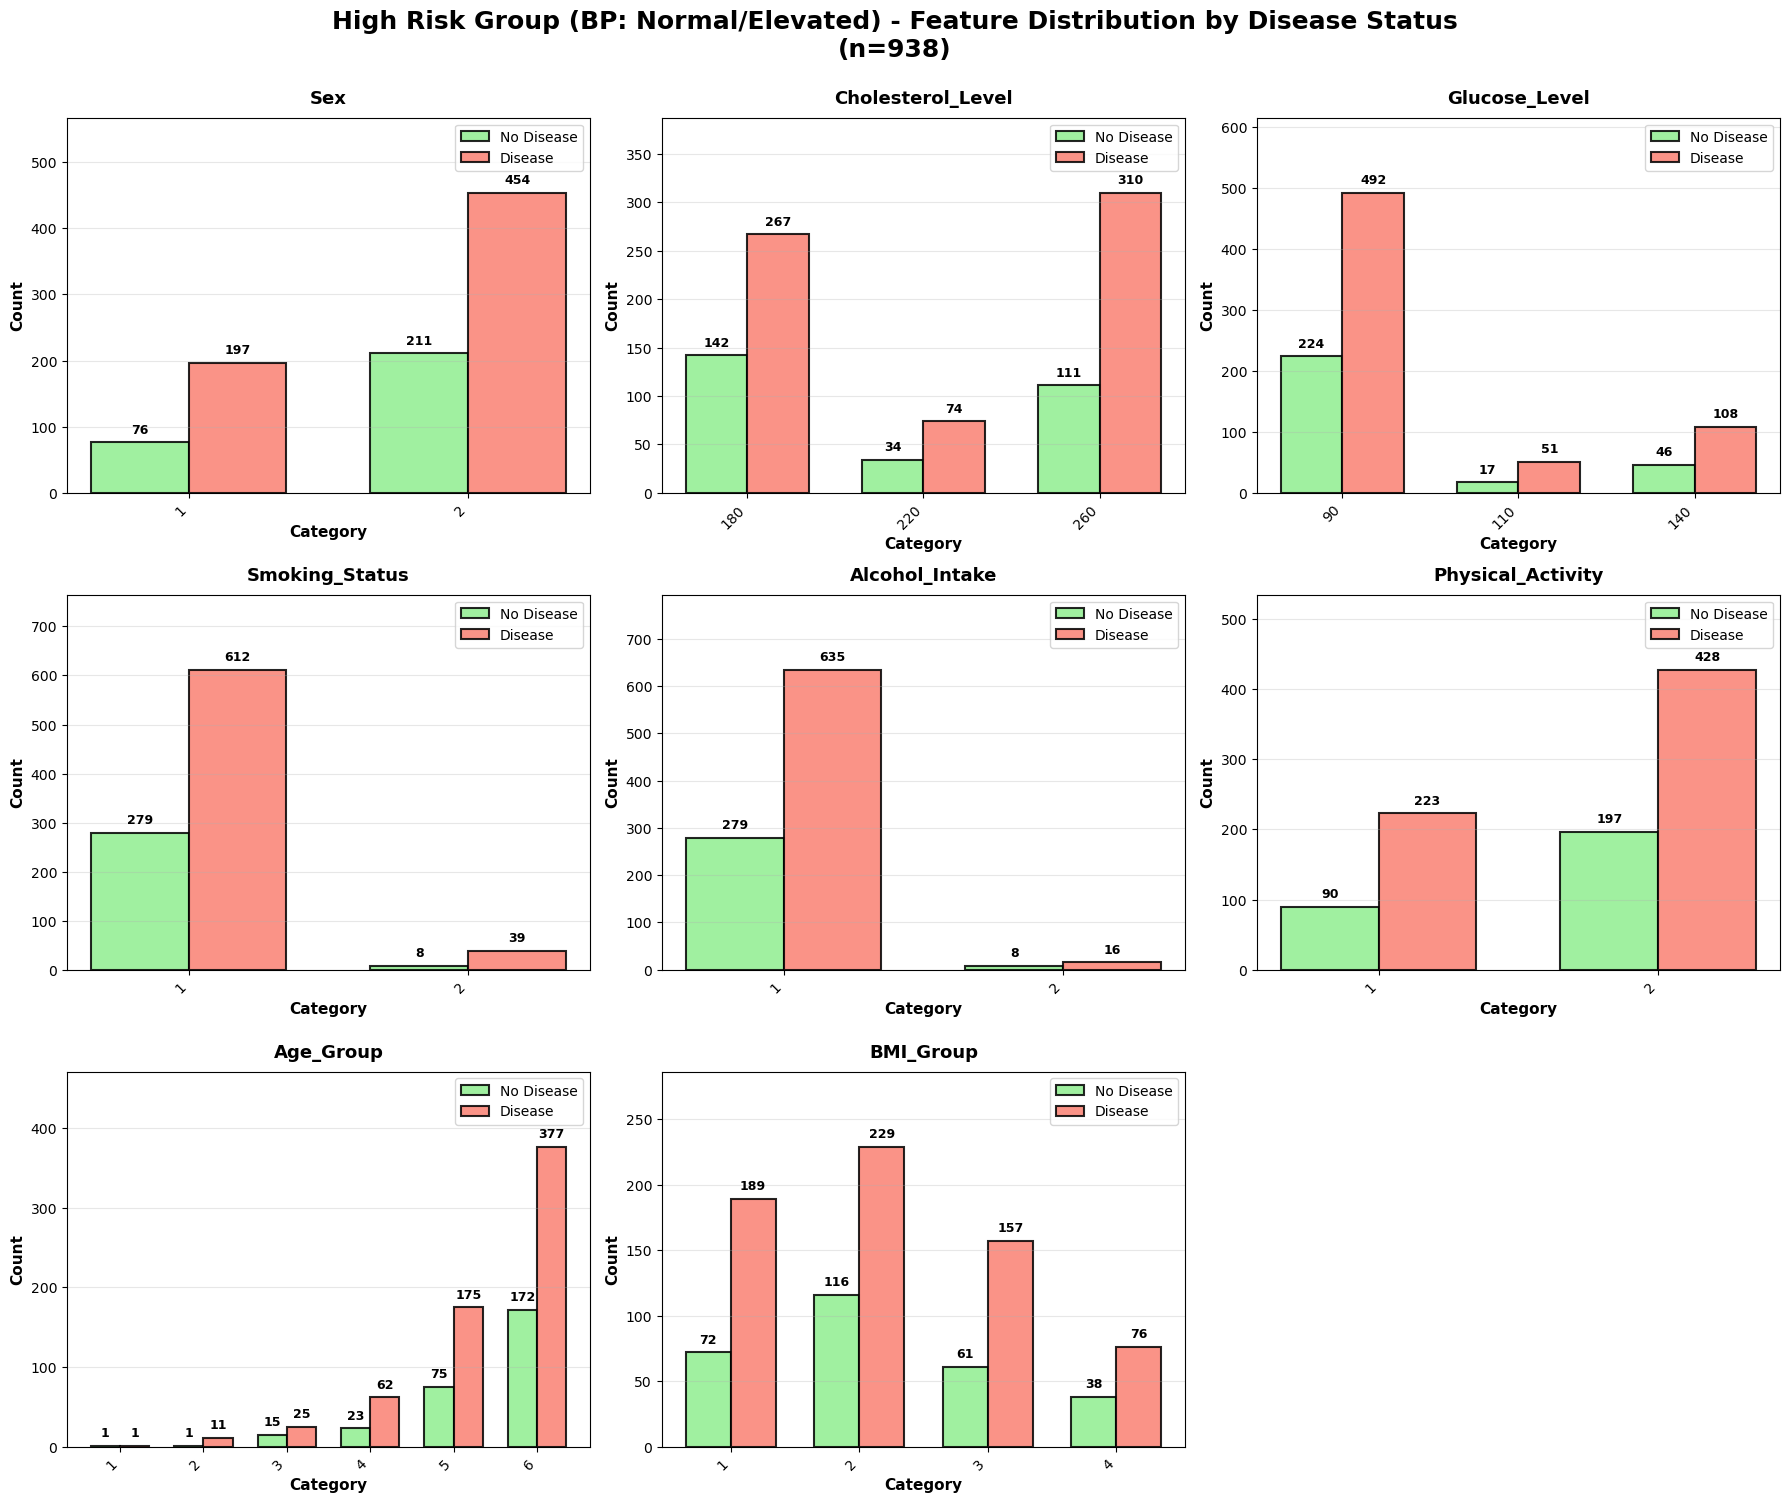

In [14]:
# ============================================================================
# HIGH RISK GROUP (BP: Normal/Elevated) - FEATURE DISTRIBUTION ANALYSIS
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

print("="*80)
print("⚡ High Risk Group - BP Normal/Elevated - Feature Analysis")
print("="*80 + "\n")

# ============================================================================
# SETUP PATHS
# ============================================================================

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling' / 'baseline model'
FIGURES_DIR = REPORTS_DIR / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================================
# CONFIGURATION
# ============================================================================

TARGET_COLORS = {'No Disease': 'lightgreen', 'Disease': 'salmon'}

# ============================================================================
# FILTER DATA - BP GROUP: NORMAL OR ELEVATED
# ============================================================================

print(f"📊 Original High Risk Group: {len(df_high_risk):,} patients\n")

# Filter for BP_Group = Normal or Elevated
bp_filter = df_high_risk['BP_Group'].isin([1, 2])  # Assuming 1=Normal, 2=Elevated
df_bp_subset = df_high_risk[bp_filter].copy()

print(f"🎯 Filtered Subset (BP: Normal/Elevated): {len(df_bp_subset):,} patients")

# Check the actual BP group distribution
print(f"\nBP Group Distribution in Subset:")
bp_counts = df_bp_subset['BP_Group'].value_counts().sort_index()
for bp_val, count in bp_counts.items():
    print(f"  BP Group {bp_val}: {count:,} ({count/len(df_bp_subset)*100:.1f}%)")

# Create target label if needed
if 'Target_Label' not in df_bp_subset.columns:
    df_bp_subset['Target_Label'] = df_bp_subset['Actual_Disease'].map({
        0: 'No Disease', 
        1: 'Disease'
    })

# Show disease distribution
print(f"\nDisease Distribution:")
disease_counts = df_bp_subset['Target_Label'].value_counts()
for label, count in disease_counts.items():
    print(f"  {label}: {count:,} ({count/len(df_bp_subset)*100:.1f}%)")
print()

# ============================================================================
# DEFINE FEATURES TO ANALYZE
# ============================================================================

features_to_analyze = [
    'Sex', 
    'Cholesterol_Level', 
    'Glucose_Level', 
    'Smoking_Status',
    'Alcohol_Intake', 
    'Physical_Activity', 
    'Age_Group',
    'BMI_Group'
    # Note: BP_Group excluded since we're filtering on it
]

# Check which features exist
available_features = [f for f in features_to_analyze if f in df_bp_subset.columns]
missing_features = [f for f in features_to_analyze if f not in df_bp_subset.columns]

print(f"✓ Available features ({len(available_features)}): {available_features}")
if missing_features:
    print(f"⚠ Missing features ({len(missing_features)}): {missing_features}")
print()

# ============================================================================
# COUNT PATIENTS BY CATEGORY FOR EACH FEATURE
# ============================================================================

feature_counts = {}

for feature in available_features:
    # Count by category and target
    counts = df_bp_subset.groupby([feature, 'Target_Label']).size().unstack(fill_value=0)
    
    # Ensure both columns exist
    if 'No Disease' not in counts.columns:
        counts['No Disease'] = 0
    if 'Disease' not in counts.columns:
        counts['Disease'] = 0
    
    counts = counts[['No Disease', 'Disease']]
    
    # Sort index
    feature_counts[feature] = counts.sort_index()

print(f"✓ Successfully counted {len(feature_counts)} features\n")

# ============================================================================
# CREATE SUBPLOT BAR PLOTS
# ============================================================================

n_features = len(feature_counts)
n_cols = 3  # 3 columns
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
fig.suptitle(f'High Risk Group (BP: Normal/Elevated) - Feature Distribution by Disease Status\n(n={len(df_bp_subset):,})', 
             fontsize=18, fontweight='bold', y=0.999)

# Flatten axes for easy iteration
if n_features > 1:
    axes = axes.flatten()
else:
    axes = [axes]

# Plot each feature
for idx, (feature_name, counts) in enumerate(feature_counts.items()):
    ax = axes[idx]
    
    x = np.arange(len(counts.index))
    width = 0.35
    
    # Create bars
    bars1 = ax.bar(x - width/2, counts['No Disease'], width,
                   label='No Disease', color=TARGET_COLORS['No Disease'],
                   edgecolor='black', alpha=0.85, linewidth=1.5)
    
    bars2 = ax.bar(x + width/2, counts['Disease'], width,
                   label='Disease', color=TARGET_COLORS['Disease'],
                   edgecolor='black', alpha=0.85, linewidth=1.5)
    
    # Set labels and title
    ax.set_title(f'{feature_name}', fontsize=13, fontweight='bold', pad=10)
    ax.set_xlabel('Category', fontsize=11, fontweight='bold')
    ax.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(counts.index, rotation=45, ha='right', fontsize=10)
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(alpha=0.3, axis='y')
    
    # Add count labels on bars
    max_height = counts.values.max() if counts.values.max() > 0 else 1
    ax.set_ylim([0, max_height * 1.25])
    
    for bar in bars1:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + max_height * 0.02,
                    f'{int(height)}', ha='center', va='bottom',
                    fontsize=9, fontweight='bold')
    
    for bar in bars2:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + max_height * 0.02,
                    f'{int(height)}', ha='center', va='bottom',
                    fontsize=9, fontweight='bold')

# Hide extra subplots if any
for idx in range(len(feature_counts), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()

# ============================================================================
# SAVE FIGURE
# ============================================================================
print(f"✅ Saved: {output_path.name}\n")
plt.show()
plt.close()

⚡ High Risk Group - BP Normal/Elevated + Age Group 1-2 - Feature Analysis

📊 Original High Risk Group: 32,032 patients

✓ After BP Filter (Normal/Elevated): 955 patients
✓ After Age Filter (Group 1-2): 11 patients

FILTER SUMMARY
Original High Risk:              32,032
After BP Filter:                 955 (3.0%)
After Age Filter (Final):        11 (0.0%)

BP Group Distribution in Final Subset:
  BP Group 1: 4 (36.4%)
  BP Group 2: 7 (63.6%)

Age Group Distribution in Final Subset:
  Age Group 1: 2 (18.2%)
  Age Group 2: 9 (81.8%)

Disease Distribution:
  Disease: 9 (81.8%)
  No Disease: 2 (18.2%)

✓ Available features (7): ['Sex', 'Cholesterol_Level', 'Glucose_Level', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity', 'BMI_Group']

✓ Successfully counted 7 features

✅ Saved: df_high_risk.png



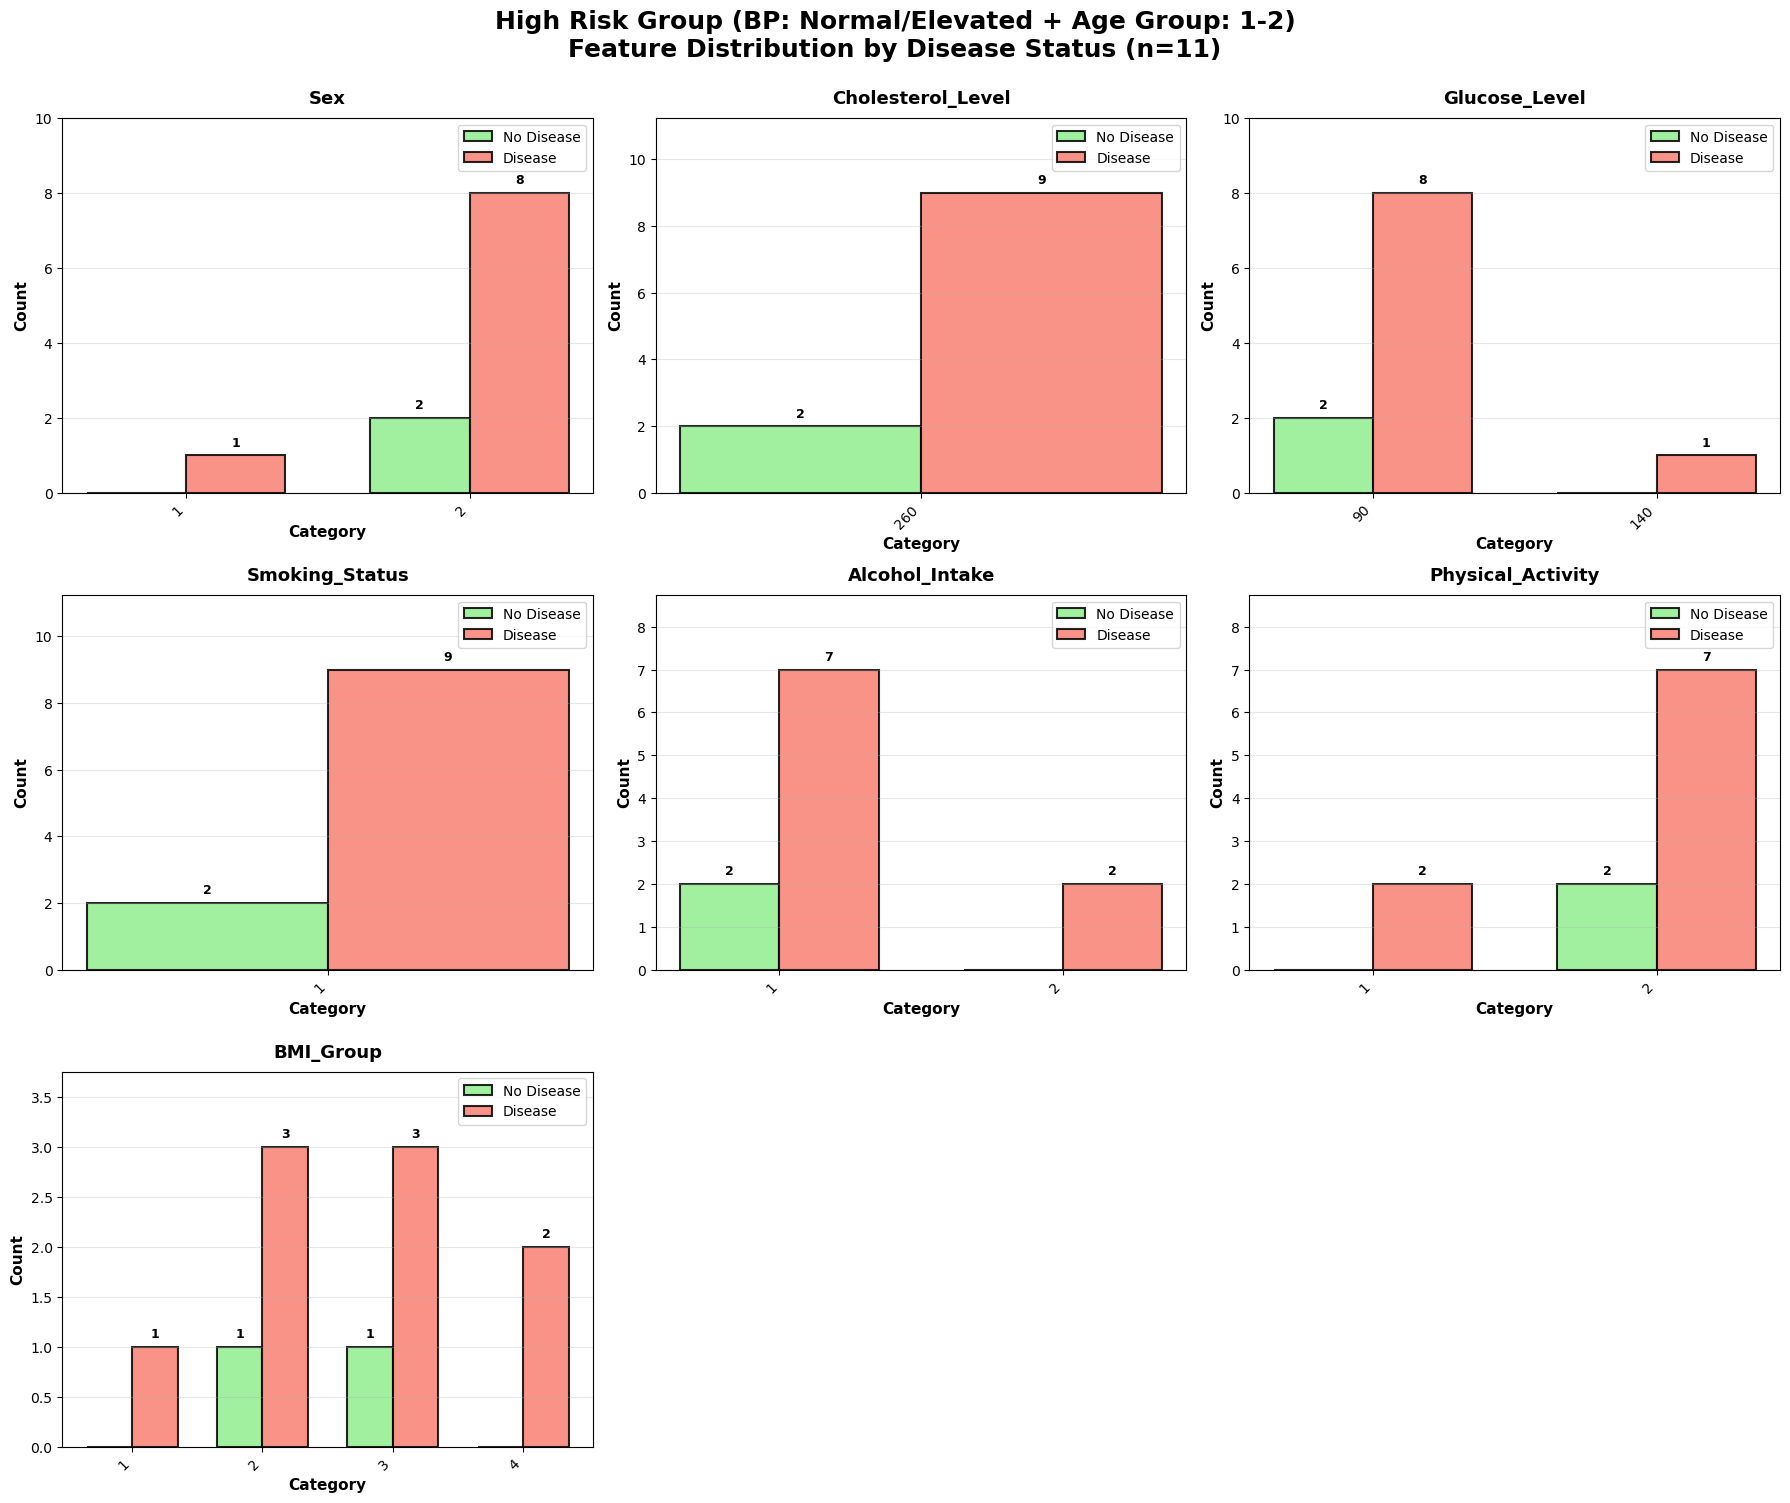

📊 DETAILED SUMMARY STATISTICS

🎯 Final Subset Breakdown:
   Total Patients: 11
   Percentage of Original High Risk: 0.0%
   Patients Lost from BP Filter: 31,077
   Patients Lost from Age Filter: 944

📋 Condition Breakdown:
   BP Group Normal (1):   4
   BP Group Elevated (2): 7
   Age Group 1:           2
   Age Group 2:           9

🏥 Disease Status:
   No Disease: 2 (18.2%)
   Disease:    9 (81.8%)

📈 Feature Analysis Summary:
   Sex                      :    11 patients | Disease:    9 (81.8%) | No Disease:    2 (18.2%)
   Cholesterol_Level        :    11 patients | Disease:    9 (81.8%) | No Disease:    2 (18.2%)
   Glucose_Level            :    11 patients | Disease:    9 (81.8%) | No Disease:    2 (18.2%)
   Smoking_Status           :    11 patients | Disease:    9 (81.8%) | No Disease:    2 (18.2%)
   Alcohol_Intake           :    11 patients | Disease:    9 (81.8%) | No Disease:    2 (18.2%)
   Physical_Activity        :    11 patients | Disease:    9 (81.8%) | No Disease:    2

In [21]:
# ============================================================================
# HIGH RISK GROUP (BP: Normal/Elevated + Age: 1-2) - FEATURE ANALYSIS
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

print("="*80)
print("⚡ High Risk Group - BP Normal/Elevated + Age Group 1-2 - Feature Analysis")
print("="*80 + "\n")

# ============================================================================
# SETUP PATHS
# ============================================================================

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling' / 'baseline model'
FIGURES_DIR = REPORTS_DIR / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================================
# CONFIGURATION
# ============================================================================

TARGET_COLORS = {'No Disease': 'lightgreen', 'Disease': 'salmon'}

# ============================================================================
# FILTER DATA - DOUBLE CONDITION
# ============================================================================

print(f"📊 Original High Risk Group: {len(df_high_risk):,} patients\n")

# FILTER 1: BP Group = Normal or Elevated (1 or 2)
bp_filter = df_high_risk['BP_Group'].isin([1, 2])
df_bp_subset = df_high_risk[bp_filter].copy()
print(f"✓ After BP Filter (Normal/Elevated): {len(df_bp_subset):,} patients")

# FILTER 2: Age Group = 1 or 2
age_filter = df_bp_subset['Age_Group'].isin([1, 2])
df_final_subset = df_bp_subset[age_filter].copy()
print(f"✓ After Age Filter (Group 1-2): {len(df_final_subset):,} patients\n")

# Show filter summary
print("="*80)
print("FILTER SUMMARY")
print("="*80)
print(f"Original High Risk:              {len(df_high_risk):,}")
print(f"After BP Filter:                 {len(df_bp_subset):,} ({len(df_bp_subset)/len(df_high_risk)*100:.1f}%)")
print(f"After Age Filter (Final):        {len(df_final_subset):,} ({len(df_final_subset)/len(df_high_risk)*100:.1f}%)")
print("="*80 + "\n")

# Check the distributions
print(f"BP Group Distribution in Final Subset:")
bp_counts = df_final_subset['BP_Group'].value_counts().sort_index()
for bp_val, count in bp_counts.items():
    print(f"  BP Group {bp_val}: {count:,} ({count/len(df_final_subset)*100:.1f}%)")

print(f"\nAge Group Distribution in Final Subset:")
age_counts = df_final_subset['Age_Group'].value_counts().sort_index()
for age_val, count in age_counts.items():
    print(f"  Age Group {age_val}: {count:,} ({count/len(df_final_subset)*100:.1f}%)")

# Create target label if needed
if 'Target_Label' not in df_final_subset.columns:
    df_final_subset['Target_Label'] = df_final_subset['Actual_Disease'].map({
        0: 'No Disease', 
        1: 'Disease'
    })

# Show disease distribution
print(f"\nDisease Distribution:")
disease_counts = df_final_subset['Target_Label'].value_counts()
for label, count in disease_counts.items():
    print(f"  {label}: {count:,} ({count/len(df_final_subset)*100:.1f}%)")
print()

# ============================================================================
# DEFINE FEATURES TO ANALYZE
# ============================================================================

features_to_analyze = [
    'Sex', 
    'Cholesterol_Level', 
    'Glucose_Level', 
    'Smoking_Status',
    'Alcohol_Intake', 
    'Physical_Activity', 
    'BMI_Group'
    # Note: BP_Group and Age_Group excluded since we're filtering on them
]

# Check which features exist
available_features = [f for f in features_to_analyze if f in df_final_subset.columns]
missing_features = [f for f in features_to_analyze if f not in df_final_subset.columns]

print(f"✓ Available features ({len(available_features)}): {available_features}")
if missing_features:
    print(f"⚠ Missing features ({len(missing_features)}): {missing_features}")
print()

# ============================================================================
# COUNT PATIENTS BY CATEGORY FOR EACH FEATURE
# ============================================================================

feature_counts = {}

for feature in available_features:
    # Count by category and target
    counts = df_final_subset.groupby([feature, 'Target_Label']).size().unstack(fill_value=0)
    
    # Ensure both columns exist
    if 'No Disease' not in counts.columns:
        counts['No Disease'] = 0
    if 'Disease' not in counts.columns:
        counts['Disease'] = 0
    
    counts = counts[['No Disease', 'Disease']]
    
    # Sort index
    feature_counts[feature] = counts.sort_index()

print(f"✓ Successfully counted {len(feature_counts)} features\n")

# ============================================================================
# CREATE SUBPLOT BAR PLOTS
# ============================================================================

n_features = len(feature_counts)
n_cols = 3  # 3 columns
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
fig.suptitle(f'High Risk Group (BP: Normal/Elevated + Age Group: 1-2)\nFeature Distribution by Disease Status (n={len(df_final_subset):,})', 
             fontsize=18, fontweight='bold', y=0.999)

# Flatten axes for easy iteration
if n_features > 1:
    axes = axes.flatten()
else:
    axes = [axes]

# Plot each feature
for idx, (feature_name, counts) in enumerate(feature_counts.items()):
    ax = axes[idx]
    
    x = np.arange(len(counts.index))
    width = 0.35
    
    # Create bars
    bars1 = ax.bar(x - width/2, counts['No Disease'], width,
                   label='No Disease', color=TARGET_COLORS['No Disease'],
                   edgecolor='black', alpha=0.85, linewidth=1.5)
    
    bars2 = ax.bar(x + width/2, counts['Disease'], width,
                   label='Disease', color=TARGET_COLORS['Disease'],
                   edgecolor='black', alpha=0.85, linewidth=1.5)
    
    # Set labels and title
    ax.set_title(f'{feature_name}', fontsize=13, fontweight='bold', pad=10)
    ax.set_xlabel('Category', fontsize=11, fontweight='bold')
    ax.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(counts.index, rotation=45, ha='right', fontsize=10)
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(alpha=0.3, axis='y')
    
    # Add count labels on bars
    max_height = counts.values.max() if counts.values.max() > 0 else 1
    ax.set_ylim([0, max_height * 1.25])
    
    for bar in bars1:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + max_height * 0.02,
                    f'{int(height)}', ha='center', va='bottom',
                    fontsize=9, fontweight='bold')
    
    for bar in bars2:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + max_height * 0.02,
                    f'{int(height)}', ha='center', va='bottom',
                    fontsize=9, fontweight='bold')

# Hide extra subplots if any
for idx in range(len(feature_counts), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()

# ============================================================================
# SAVE FIGURE
# ============================================================================


print(f"✅ Saved: {output_path.name}\n")
plt.show()
plt.close()

# ============================================================================
# DETAILED SUMMARY STATISTICS
# ============================================================================

print("="*80)
print("📊 DETAILED SUMMARY STATISTICS")
print("="*80)

print(f"\n🎯 Final Subset Breakdown:")
print(f"   Total Patients: {len(df_final_subset):,}")
print(f"   Percentage of Original High Risk: {len(df_final_subset)/len(df_high_risk)*100:.1f}%")
print(f"   Patients Lost from BP Filter: {len(df_high_risk) - len(df_bp_subset):,}")
print(f"   Patients Lost from Age Filter: {len(df_bp_subset) - len(df_final_subset):,}")

print(f"\n📋 Condition Breakdown:")
print(f"   BP Group Normal (1):   {(df_final_subset['BP_Group'] == 1).sum():,}")
print(f"   BP Group Elevated (2): {(df_final_subset['BP_Group'] == 2).sum():,}")
print(f"   Age Group 1:           {(df_final_subset['Age_Group'] == 1).sum():,}")
print(f"   Age Group 2:           {(df_final_subset['Age_Group'] == 2).sum():,}")

print(f"\n🏥 Disease Status:")
no_disease = (df_final_subset['Target_Label'] == 'No Disease').sum()
disease = (df_final_subset['Target_Label'] == 'Disease').sum()
print(f"   No Disease: {no_disease:,} ({no_disease/len(df_final_subset)*100:.1f}%)")
print(f"   Disease:    {disease:,} ({disease/len(df_final_subset)*100:.1f}%)")

print(f"\n📈 Feature Analysis Summary:")
for feature_name, counts in feature_counts.items():
    total = counts.sum().sum()
    disease_count = counts['Disease'].sum()
    no_disease_count = counts['No Disease'].sum()
    print(f"   {feature_name:25s}: {total:>5,} patients | Disease: {disease_count:>4,} ({disease_count/total*100:.1f}%) | No Disease: {no_disease_count:>4,} ({no_disease_count/total*100:.1f}%)")

# Cross-tabulation: BP Group vs Age Group with Disease Status
print(f"\n🔍 Cross-Tabulation: BP Group × Age Group × Disease Status:")
cross_tab = df_final_subset.groupby(['BP_Group', 'Age_Group', 'Target_Label']).size().unstack(fill_value=0)
print(cross_tab)

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE")
print("="*80)

### Error analysis - Top important error rates